In [1]:
# datasets from https://www.kaggle.com/competitions/nlp-getting-started/overview downloaded into a 'NLP tweets kaggle' folder

In [2]:
# adding libraries for UI elements and graphs
import plotly
import plotly.express as px
import plotly.graph_objects as go

# DATA EXPLORATION AND VISUALISATION

In [3]:
import pandas as pd

In [5]:
df = pd.read_csv(r"C:\Users\Tooba Shaukat\Downloads\Projects Data Science\NLP tweets kaggle\data files\train.csv")
test_df = pd.read_csv(r"C:\Users\Tooba Shaukat\Downloads\Projects Data Science\NLP tweets kaggle\data files\test.csv")

1. the real purpose of this data challenge

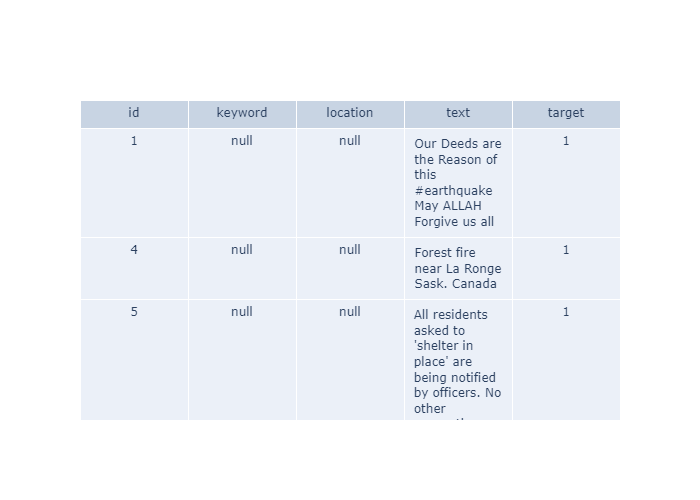

In [6]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(df.columns)),
    cells=dict(values=[df.id,df.keyword,df.location,df.text,df.target]))
])

#fig.show()
fig.show("png")

The challenge consists of being able to differentiate tweets that contain words that could be related to a disaster and that are actually about a disaster from tweets that may contain the same words but that are not related to a disaster.</br></br> It is a binary classification problem.

The "keyword" column gives an idea of some words that may be considered as disaster-related

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Duplicates could be identical tweets from distinct users or same users. The fact that a tweet has been retweeted could have a meaning/weight, but it is not sure.

In [9]:
any(df['text'].duplicated())

True

Dropping the duplicates

In [10]:
df.drop_duplicates(subset= ['text'], keep='first', inplace= True)

revarifying the duplicates

In [12]:
any(df['text'].duplicated())

False

Looking for the NAN values in the dataset

In [13]:
df.isna().sum()

id             0
keyword       56
location    2482
text           0
target         0
dtype: int64

2. exploring all the features in the dataset

a. id

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7503 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7503 non-null   int64 
 1   keyword   7447 non-null   object
 2   location  5021 non-null   object
 3   text      7503 non-null   object
 4   target    7503 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 351.7+ KB


In [14]:
len(df.id.unique())

7503

conclusion : unique id for all entries

b. keyword

In [16]:
len(df.keyword.unique())

222

In [17]:
df_k = df['keyword'].value_counts().to_frame().reset_index()

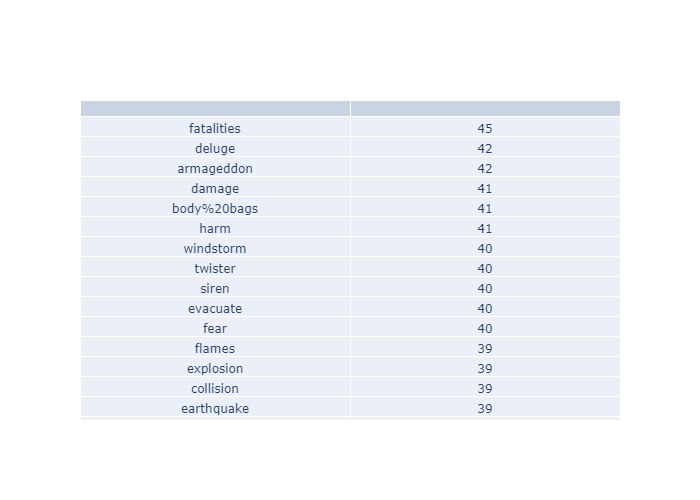

In [18]:
fig = go.Figure(data=[go.Table(
    cells=dict(values=[df_k['index'],df_k.keyword]
    ))
])
#fig.show()
fig.show("png")

Is the keyword always contained in content? Does the keyword add an interpretative value to the content?

In [19]:
df_keywords = df.copy().dropna(axis=0, subset=['keyword'])

In [20]:
#lowercasing to enable comparison
df_keywords['text'] = df_keywords['text'].apply(lambda x: x.lower())

In [21]:
df_keywords['contained'] = df_keywords.apply(lambda x: x.keyword in x.text, axis=1)

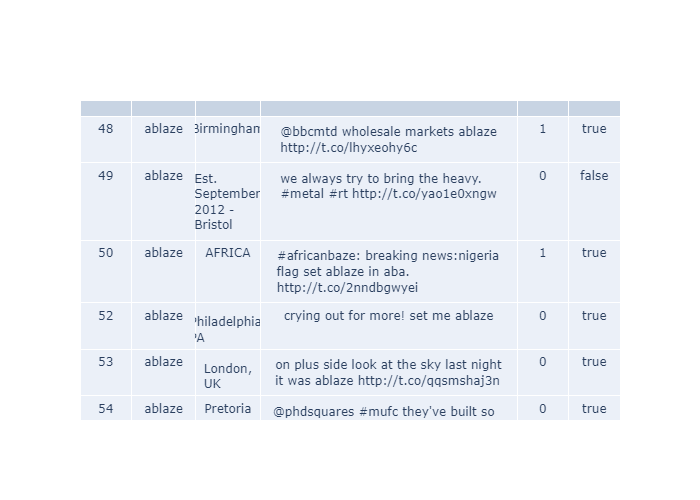

In [22]:
fig = go.Figure(data=[go.Table(
    columnwidth = [80,100,100,400,80,80],
    cells=dict(values=df_keywords.transpose().values.tolist())
    )
])
#fig.show()
fig.show("png")

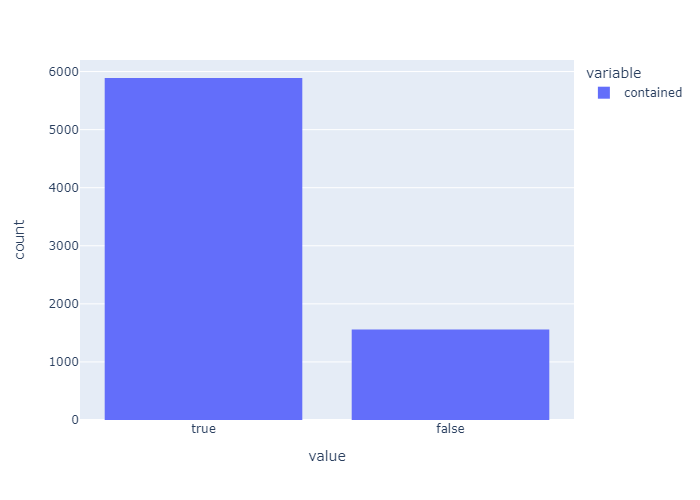

In [23]:
fig = px.histogram(df_keywords['contained'])
#fig.show()
fig.show("png")

Most often, keyword is contained in the content. </br> After observing the table above, it seems that when the keyword is not included, it does not seem to always add an interpretative value to the content, and sometimes the meaning seems completely disconnected.

The keyword column can consequently be removed.

c. location

In [24]:
len(df.location.unique())

3328

In [25]:
df_loc = df['location'].value_counts().to_frame().reset_index()

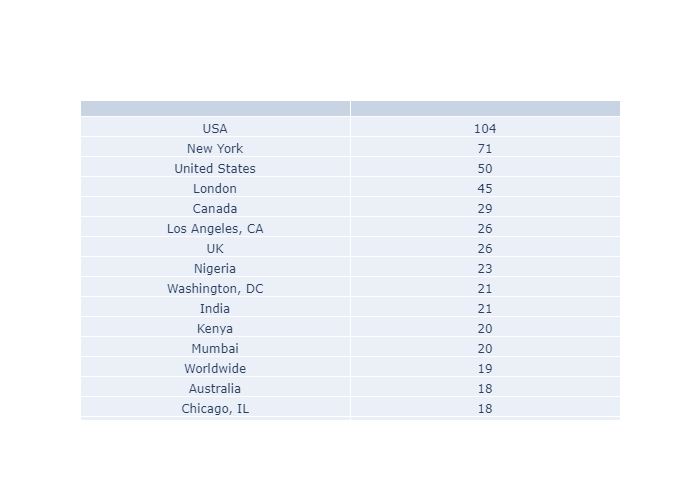

In [26]:
fig = go.Figure(data=[go.Table(
    cells=dict(values=[df_loc['index'],df_loc.location]))
])
#fig.show()
fig.show("png")

There are more than 2.000 nans in the location and location names are not standardised, which makes it difficult to process. Moreover, locations are not always real locations.

The location column will consequently be removed for now.

d. Target

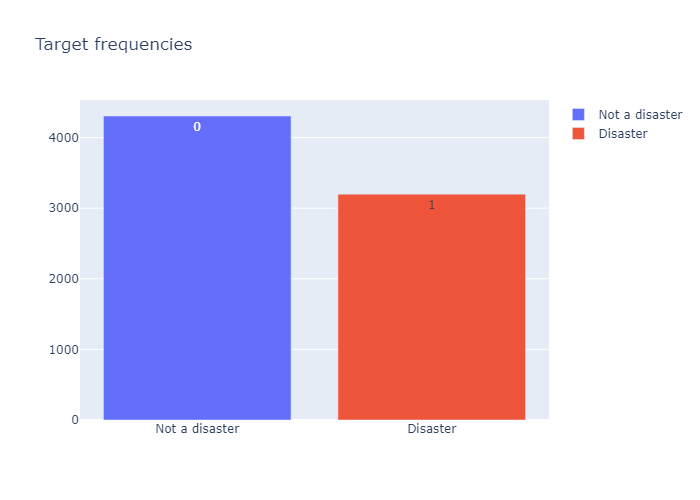

In [27]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Not a disaster'],
    y=[df['target'].value_counts()[0]],
    name='Not a disaster',
    text=[0],
    textposition='auto'
))
fig.add_trace(go.Bar(
    x=['Disaster'],
    y=[df['target'].value_counts()[1]],
    name='Disaster',
    text=[1],
    textposition='auto'
))
fig.update_layout(
    title='Target frequencies'
)
# fig.show()
fig.show("png")


There are more tweets that are not a disaster than the opposite.

# TEXT PREPROCESSING

In [36]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string

[nltk_data] Downloading package stopwords to C:\Users\Tooba
[nltk_data]     Shaukat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
df_pre = df[['text','target']].copy()

In [54]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

In [55]:
import unicodedata

stop_words = stopwords.words('english')+['lien']

# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    r = re.compile(r"https?://[A-Za-z0-9\.\-/]+")
    w = r.sub("<lien>", w)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ",")
    w = re.sub(r"[^a-zA-Z]",' ', w)
    w = re.sub(r'\b\w{0,2}\b', '', w)

    w = remove_url(w)
    w = remove_emoji(w)
    w = remove_html(w)
    # remove stopword
    mots = word_tokenize(w.strip())
    mots = [mot for mot in mots if mot not in stop_words]
    return ' '.join(mots).strip()


In [56]:
df_pre.text = df_pre.text.apply(lambda x :preprocess_sentence(x))

In [58]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(df_pre.columns)),
    cells=dict(values=[df_pre.text,df_pre.target]))
])

fig.show()
#fig.show("png")

# Visualisation of text using wordclouds

In [59]:
# separating df into disaster and non disaster tweets

df_disaster = df_pre[df_pre.target == 1]
df_nondisaster = df_pre[df_pre.target == 0]


In [60]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [61]:
wc = WordCloud(background_color="black", max_words=100, stopwords=stop_words, max_font_size=50, random_state=42)

In [62]:
text_disaster = ""
for words in df_disaster.text : 
    text_disaster += words

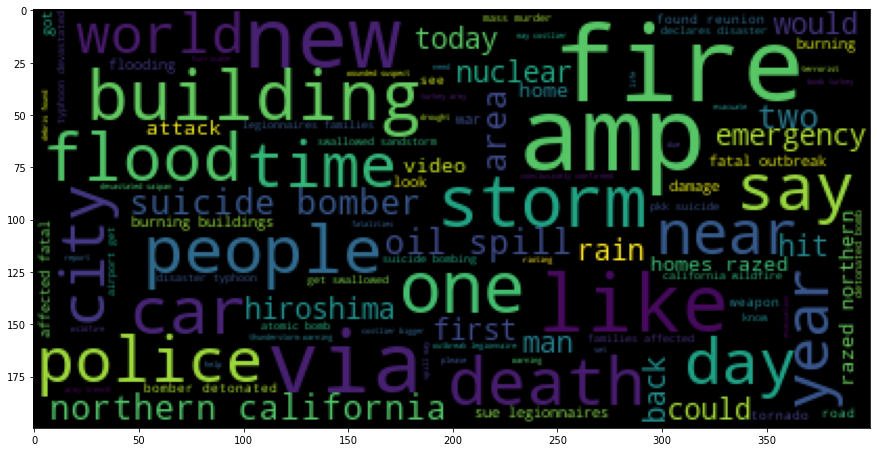

In [63]:

plt.figure(figsize= (15,15)) # Initialisation d'une figure
wc.generate(text_disaster)           # "Calcul" du wordcloud
plt.imshow(wc) # Affichage
plt.show()

In [64]:
text_nondisaster = ""
for words in df_nondisaster.text : 
    text_nondisaster += words

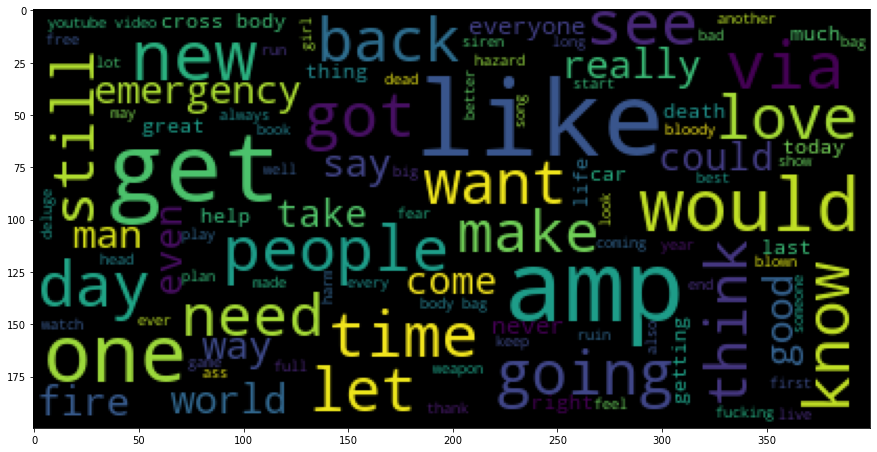

In [65]:

plt.figure(figsize= (15,15)) # Initialisation d'une figure
wc.generate(text_nondisaster)           # "Calcul" du wordcloud
plt.imshow(wc) # Affichage
plt.show()

# MODELISATION

In [66]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
import xgboost as xgb
import numpy as np

C:\Users\Tooba Shaukat\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [67]:
all_text = " ".join(df_pre["text"].values)
all_words = all_text.split()
all_words = set(all_words)
numwords = len(all_words)

In [68]:
x = df_pre['text']
y = df_pre['target']

In [69]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1234)

In [70]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=numwords)

tokenizer.fit_on_texts(x_train)

X_train = tokenizer.texts_to_sequences(x_train)

X_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(x_train.shape)
print(len(X_train))

(5627,)
5627


In [71]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 33

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)

X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print("X_train", len(X_train))
print("X_test", len(X_test))

X_train 5627
X_test 1876


In [72]:
embedding_dim = 20

In [74]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Embedding, Dense, GlobalMaxPooling1D, SpatialDropout1D, Conv1D

In [80]:
model = Sequential()
model.add(layers.Embedding(numwords*2, embedding_dim, input_length=maxlen))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.Conv1D(64, 2, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(24, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) #  sigmoid

         
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 33, 20)            632840    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 33, 20)           0         
 lDropout1D)                                                     
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 64)            2624      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 24)                1560      
                                                                 
 dense_3 (Dense)             (None, 1)                

In [81]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [82]:
history = model.fit(X_train, y_train,
    epochs=5,
    validation_split=0.3, 
    verbose=2)

Epoch 1/5
124/124 - 3s - loss: 0.6732 - accuracy: 0.5907 - val_loss: 0.6152 - val_accuracy: 0.7194 - 3s/epoch - 21ms/step
Epoch 2/5
124/124 - 1s - loss: 0.4461 - accuracy: 0.8271 - val_loss: 0.4639 - val_accuracy: 0.7886 - 1s/epoch - 10ms/step
Epoch 3/5
124/124 - 1s - loss: 0.2430 - accuracy: 0.9096 - val_loss: 0.5146 - val_accuracy: 0.7845 - 1s/epoch - 10ms/step
Epoch 4/5
124/124 - 1s - loss: 0.1260 - accuracy: 0.9596 - val_loss: 0.6013 - val_accuracy: 0.7726 - 1s/epoch - 10ms/step
Epoch 5/5
124/124 - 1s - loss: 0.0749 - accuracy: 0.9769 - val_loss: 0.6839 - val_accuracy: 0.7602 - 1s/epoch - 11ms/step


In [85]:
df_hist = pd.DataFrame(history.history)
df_hist

loss  accuracy  val_loss  val_accuracy
0  0.673185  0.590655  0.615182      0.719361
1  0.446064  0.827070  0.463861      0.788632
2  0.242956  0.909599  0.514627      0.784488
3  0.125951  0.959624  0.601290      0.772647
4  0.074851  0.976892  0.683928      0.760213

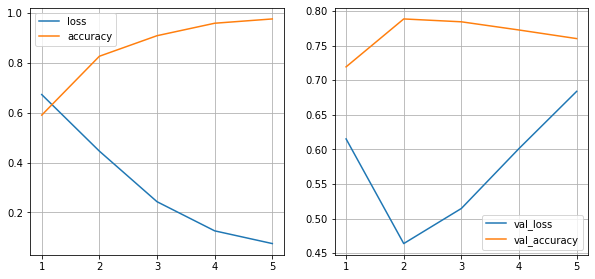

In [86]:
epochs = 5
x = np.arange(1,epochs+1)
x = pd.Series(x)
x = x.astype(str)
y1 = history.history["loss"]
y2 = history.history["accuracy"]
y3 = history.history["val_loss"]
y4 = history.history["val_accuracy"]
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(x,y1,label="loss")
plt.plot(x,y2,label="accuracy")
plt.grid()
plt.legend()

plt.subplot(2,2,2)
plt.plot(x,y3,label="val_loss")
plt.plot(x,y4,label="val_accuracy")
plt.grid()
plt.legend()
plt.show()

In [87]:
model.evaluate(X_test, y_test)

59/59 [==============================] - 0s 2ms/step - loss: 0.7662 - accuracy: 0.7591


[0.7662402987480164, 0.7590618133544922]

In [88]:
y_pred = model.predict(X_test)

In [91]:
#Appliquer la méthode argmax du tableau y_pred pour obtenir les classes les plus probable

y_pred_class = y_pred.argmax(axis = 1)

In [92]:
from sklearn.metrics import classification_report

In [94]:
print( classification_report(y_test, y_pred_class) )

              precision    recall  f1-score   support

           0       0.58      1.00      0.73      1079
           1       0.00      0.00      0.00       797

    accuracy                           0.58      1876
   macro avg       0.29      0.50      0.37      1876
weighted avg       0.33      0.58      0.42      1876



C:\Users\Tooba Shaukat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Tooba Shaukat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Tooba Shaukat\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# PREDICTING THE VALUES FOR TEST FILE

In [95]:
test_df = pd.read_csv(r"C:\Users\Tooba Shaukat\Downloads\Projects Data Science\NLP tweets kaggle\data files\test.csv")

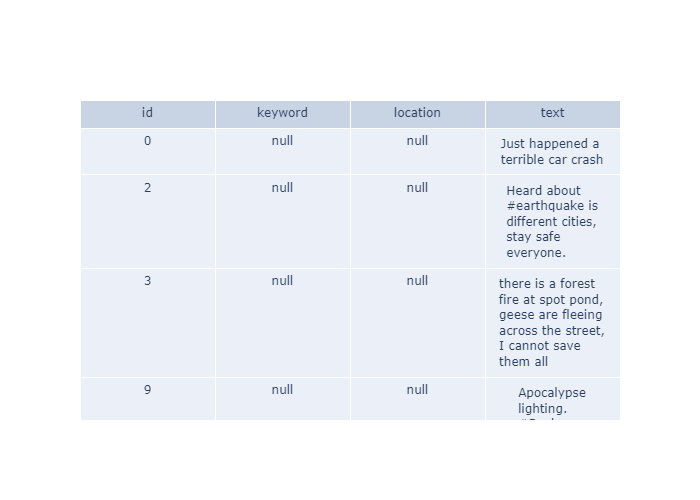

In [96]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(test_df.columns)),
    cells=dict(values=[test_df.id,test_df.keyword,test_df.location,test_df.text]))
])

#fig.show()
fig.show("png")

In [98]:
test_df_pre = test_df[['id','text']].copy()

In [100]:
test_df_pre.text = test_df_pre.text.apply(lambda x :preprocess_sentence(x))

In [102]:
submission = test_df_pre

In [103]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3263 non-null   int64 
 1   text    3263 non-null   object
dtypes: int64(1), object(1)
memory usage: 51.1+ KB


In [106]:
x_test = test_df_pre["text"]

In [107]:
x_test = tokenizer.texts_to_sequences(x_test)

x_test = pad_sequences(x_test, maxlen=33)

In [108]:
def to_0_or_1(predict):
    if predict>0.5:
        x = 1
    else:
        x = 0
    return x

sub_pre = model.predict(x_test)
sub_pre = sub_pre.flatten()

ans = pd.Series(sub_pre)
ans = ans.apply(lambda x:to_0_or_1(x))
ans_count = ans.value_counts()

In [110]:
submission["target"] = ans

In [112]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(submission.columns)),
    cells=dict(values=[submission.id,submission.text, submission.target]))
])

fig.show()
#fig.show("png")

In [113]:
submission["target"].value_counts()

0    1954
1    1309
Name: target, dtype: int64

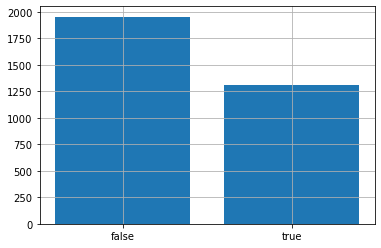

In [114]:
plt.grid()
plt.bar(["false","true"],ans_count)
plt.show()

In [115]:
submission.to_pickle('submission.pkl')

In [116]:
submission = pd.read_pickle('submission.pkl')

In [117]:
submission.head(50)

id                                               text  target
0     0                        happened terrible car crash       1
1     2  heard earthquake different cities stay safe ev...       1
2     3  forest fire spot pond geese fleeing across str...       1
3     9              apocalypse lighting spokane wildfires       1
4    11                typhoon soudelor kills china taiwan       1
5    12                                 shaking earthquake       1
6    21         probably still show life arsenal yesterday       0
7    22                                                hey       0
8    27                                           nice hat       0
9    29                                               fuck       0
10   30                                          like cold       0
11   35                                         nooooooooo       0
12   42                                               tell       0
13   43                                                          0
14   45                                            awesome       0
15   46  birmingham wholesale market ablaze bbc news fi...       1
16   47             sunkxssedharry wear shorts race ablaze       0
17   51  previouslyondoyintv toke makinwa marriage cris...       1
18   58                                         check nsfw       0
19   60  psa splitting personalities techies follow abl...       0
20   69          beware world ablaze sierra leone amp guap       0
21   70            burning man ablaze turban diva via etsy       0
22   72  diss song people take thing run smh eye opener...       0
23   75  rape victim dies sets ablaze year old girl die...       1
24   84                                     setting ablaze       1
25   87  ctvtoronto bins front field house wer set abla...       0
26   88      nowplaying alfons ablaze puls radio pulsradio       0
27   90  burning rahm let hope city hall builds giant w...       0
28   94  philippaeilhart dhublath hurt eyes ablaze insu...       0
29   99  accident cleared paturnpike patp cranberry slo...       1
30  101  got love burning self damn curling wand swear ...       0
31  103                         hate badging shit accident       1
32  106  car recorder zeroedgea dual lens car camera ve...       1
33  108  coincidence curse still unresolved secrets pas...       0
34  111  traffic southe roadpol east accident near lewe...       1
35  115  sakuma pretend feel certain way feeling become...       0
36  116  legal medical referral service injured call ac...       1
37  122  construction guy working disney store huge gau...       0
38  123  robynjilllian wlsdomteeths feel like going acc...       0
39  124  northbound junctions currently delays mins due...       1
40  125  daveoshry soembie say met accident week would ...       0
41  127  accident hit run cold block vista ter gresham ...       1
42  140                   calum sos happened accident like       1
43  142  please donate spread word training accident le...       1
44  147  please like share new page indoor trampoline p...       0
45  148  bxckylynch foi roh aftershock las vegas procur...       0
46  150  schoolboy aftershock original mix excision amp...       0
47  152  icemoon aftershock djicemoon dubstep trapmusic...       0
48  154  aftershock happened nepal last int team still ...       0
49  155  icemoon aftershock djicemoon dubstep trapmusic...       0

In [118]:
submission.tail(50)

id                                               text  target
3213  10668  salt wounds isnt burnin used dont feel pain af...       0
3214  10670                     character recover fromaewounds       1
3215  10674  dentists tell much mouth pain numbing wears pu...       0
3216  10683  wounds easily turn people want hardly see happ...       0
3217  10694  sitting parking lot waiting therapy crying emo...       0
3218  10697  last week blast hosting dinner amp movie night...       1
3219  10699  figured get music rental car take night drive ...       0
3220  10701             emotional wreck watching emmerdale fml       0
3221  10703  interesting watching train wreck taking acid k...       1
3222  10713  dukeskywalker facialabuse competetion xxxmrboo...       1
3223  10714  man faces manslaughter charges following fatal...       1
3224  10716                   wreck gives ppl lifestyle advice       0
3225  10717  emotional wreck someone hold upload damn video...       0
3226  10719  added video youtube playlist burnt black nervo...       0
3227  10725                                wreck uneven layers       0
3228  10728                                     wreck cut beat       0
3229  10734  herologist know right train wreck believe happ...       0
3230  10738           wreckage conclusively confirmed malaysia       1
3231  10740  wreckage conclusively confirmed malaysia inves...       1
3232  10742           wreckage conclusively confirmed malaysia       1
3233  10756  wreckage conclusively confirmed malaysia inves...       1
3234  10757  science piece wreckage flight confirmed union ...       1
3235  10758           wreckage conclusively confirmed malaysia       1
3236  10761  wreckage conclusively confirmed malaysia inves...       1
3237  10762  top story wreckage officially confirmed janisc...       1
3238  10773  wreckage conclusively confirmed malaysia via ndtv       1
3239  10778  wreckage conclusively confirmed malaysia inves...       1
3240  10781  australian debris found indian ocean island co...       1
3241  10791             cramer iger words wrecked disney stock       0
3242  10792  almost wrecked van day guy yeah brake amp also...       0
3243  10796  manner human would parcel baby though wrecked ...       0
3244  10797  nathan rfc thought said saturday night near di...       0
3245  10801                 wan na ease mind make feel alright       0
3246  10804  yakuboobs think deactivated notifications aids...       0
3247  10806  cnbc words disney ceo bob iger wrecked disney ...       0
3248  10807  smackdown tyme put good mood since got wrecked...       0
3249  10816  thrillhho jsyk stopped thinking abt remus slum...       0
3250  10820  stighefootball begovic garbage got wrecked red...       0
3251  10828                         wrecked today got hattrick       0
3252  10836  ebola ebolaoutbreak ebola virus birmingham ala...       1
3253  10838           malaysian confirms debris missing flight       1
3254  10845  officials alabama home quarantined possible eb...       1
3255  10856  see old pkk suicide bomber detonated bomb turk...       1
3256  10857  conference attendees blue line airport deraile...       1
3257  10858  death toll suicide car bombing ypg position vi...       1
3258  10861  earthquake safety los angeles safety fasteners...       1
3259  10865  storm worse last hurricane city amp others har...       1
3260  10868                      green line derailment chicago       1
3261  10874           meg issues hazardous weather outlook hwo       1
3262  10875  cityofcalgary activated municipal emergency pl...       1